# 3D Liver Segmentation using MONAI

## Introduction

Liver segmentation is crucial in medical imaging for diagnosis and treatment planning. Deep learning has significantly enhanced the accuracy of automated segmentation.

## MONAI Framework

MONAI (Medical Open Network for AI) is a PyTorch-based framework that simplifies developing deep learning models for healthcare imaging. It provides tools for data loading, preprocessing, augmentation, and model building.

## Objectives


1. **Data Preparation**: Loading and preprocessing 3D medical images.
2. **Data Augmentation**: Applying augmentation techniques.
3. **Model Building**: Constructing and training a segmentation model.
4. **Evaluation**: Assessing the model's performance.


# Installation and Setup for 3D Liver Segmentation using MONAI

To begin with 3D liver segmentation using MONAI, we need to install the necessary libraries and ensure our environment is properly set up. Below is the explanation of the code to achieve this:




In [1]:
import torch

# Check if a GPU is available
gpu_available = torch.cuda.is_available()

# Print the result
print(f"GPU is available: {gpu_available}")

# Optionally, print the name of the GPU if available
if gpu_available:
    print(f"GPU name: {torch.cuda.get_device_name(0)}")


GPU is available: True
GPU name: NVIDIA GeForce RTX 4070


In [2]:
import os  # For interacting with the operating system, such as file and directory operations
import shutil  # For high-level file operations like copying and removing files
import tempfile  # For creating temporary files and directories

import matplotlib.pyplot as plt  # For creating visualizations and plots
from tqdm import tqdm  # For displaying progress bars
import monai.transforms
from monai.losses import DiceCELoss  # For combining Dice and Cross-Entropy loss functions
from monai.inferers import sliding_window_inference  # For applying inference on large images using a sliding window approach
from monai.transforms import (  # For various data transformation operations
    AsDiscrete,  # For converting predictions to discrete values
    EnsureChannelFirstd,  # For ensuring the first dimension is the channel dimension
    Compose,  # For composing multiple transforms together
    CropForegroundd,  # For cropping out the foreground from the images
    LoadImaged,  # For loading images from files
    Orientationd,  # For setting the image orientation
    RandFlipd,  # For randomly flipping the image
    RandCropByPosNegLabeld,  # For randomly cropping the image by positive and negative labels
    RandShiftIntensityd,  # For randomly shifting the intensity of the image
    ScaleIntensityRanged,  # For scaling the intensity of the image to a specific range
    Spacingd,  # For resampling image spacing
    RandRotate90d,  # For randomly rotating the image by 90 degrees
    ResizeWithPadOrCropd,  # For resizing the image by padding or cropping
    SpatialCrop  # For cropping the image spatially
)

from monai.config import print_config  # For printing the configuration of the MONAI environment
from monai.metrics import DiceMetric  # For calculating the Dice metric for evaluation
from monai.networks.nets import UNet, VNet, AHNet  # For defining neural network architectures

from monai.data import (  # For handling data loading and processing
    CacheDataset,  # For caching the dataset in memory
    DataLoader,  # For loading the dataset in batches
    Dataset,  # For defining a dataset
    load_decathlon_datalist,  # For loading data lists from the Decathlon dataset
    decollate_batch,  # For splitting batches into individual items
)

from monai.networks.layers import Norm  # For normalization layers in neural networks
import torch  # For PyTorch library, used for deep learning models
from monai.handlers.utils import from_engine  # For extracting data from the engine's output
from monai.apps import download_and_extract  # For downloading and extracting datasets
import numpy as np
from numpy import random
from monai.data import PatchDataset, DataLoader, PatchIter
import matplotlib.pyplot as plt
import asyncio
import glob  # For finding files and directories matching a specified pattern
import torch
print_config()  # Print the MONAI configuration and environment details


MONAI version: 1.4.dev2431
Numpy version: 2.1.0
Pytorch version: 2.4.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 951a77d7a7737a3108afa94623a50b87d21eb4a7
MONAI __file__: c:\Users\<username>\miniconda3\envs\monai\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.14.1
Pillow version: 10.4.0
Tensorboard version: 2.17.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.19.0
tqdm version: 4.66.5
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 6.0.0
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.8.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLE

# Preparing the Image List for Training

This section of the code is responsible for creating a list of image files that will be used for training a 3D liver segmentation model. It involves loading images, filtering based on specific criteria, and preparing a final list of images suitable for training.



## Handling Large Neuroimaging Datasets with GPU Resources
In the process of preparing neuroimaging data for training deep learning models, we often encounter situations where certain criteria must be applied to filter the dataset based on specific requirements. One such criterion is based on the dimensions of the images, specifically the third dimension (e.g., the number of slices in a 3D volume).

### Current Approach: Filtering by Dimension
In the provided script, the following line is used to filter out images whose third dimension is less than 450:

```python
if n1_img_sh[2] < 450:
    img_files_for_training.append(file)
```
**This condition ensures that only those images with a third dimension smaller than 450 are included in the training set. This is typically done to manage memory usage, reduce computational load, or focus on a specific subset of the data that meets certain dimensional constraints.**

### Expanding to the Full Dataset
If you have access to a powerful GPU with ample memory, you might want to use the entire dataset without filtering out images based on their dimensions. In such cases, you can simply comment out or remove the filtering condition:

```python
# if n1_img_sh[2] < 450:
  img_files_for_training.append(file)
```
**By commenting out or removing these lines, the script will include all image files in the training set, regardless of their dimensions. This approach allows you to leverage the full dataset, which can potentially improve model performance by providing more comprehensive training data.**

In [3]:
import os
import nibabel as nib  # Import nibabel for handling neuroimaging data (e.g., NIfTI files)

# Set the path to your local directory
local_directory = r'C:\Users\ojshav\Desktop\liver'

# Create a list of image files from the specified directory
img_files = [os.path.join(path[0], file) for path in os.walk(local_directory) for file in path[-1] if 'pt' in path[0] if 'vol' in file]

# Display the number of image files found
print(f"Number of image files found: {len(img_files)}")

# Initialize an empty list to store image files that meet the criteria for training
img_files_for_training = []

# Iterate through the list of image files
for file in img_files:
    # Load the image file using nibabel and get its data shape
    n1_img_sh = nib.load(file).header.get_data_shape()

    # If the third dimension of the image is less than 450, add it to the training list
    if n1_img_sh[2] < 450:
        img_files_for_training.append(file)

# Display the number of image files selected for training
print(f"Number of image files selected for training: {len(img_files_for_training)}")


Number of image files found: 131
Number of image files selected for training: 67


# Preparing Segmentation Files and Creating Data Dictionaries

In this section, the code prepares the segmentation files corresponding to the training images and then constructs dictionaries suitable for use with MONAI's dataset handling. Finally, the data is split into training, validation, and test sets.



In [4]:
# Define the path to the segmentation files in your local directory
seg_path = r'C:\Users\ojshav\Desktop\liver\liver-tumor-segmentation\segmentations\\'

# Create a list of segmentation files corresponding to the training image files
seg_files = [os.path.join(seg_path, 'segmentation-' + file.split('-')[-1]) for file in img_files_for_training]

# Print one example of image and corresponding segmentation file paths
print(img_files_for_training[2], seg_files[2])


C:\Users\ojshav\Desktop\liver\liver-tumor-segmentation\volume_pt3\volume-21.nii C:\Users\ojshav\Desktop\liver\liver-tumor-segmentation\segmentations\\segmentation-21.nii


In [5]:
# Create a list of dictionaries, each containing an image file and its corresponding segmentation file
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(img_files_for_training, seg_files)]

# Split the data into training, validation, and test sets
train_files, val_files, test_files = data_dicts[:-17], data_dicts[-17:-10], data_dicts[-7:]

In [6]:
# Load one image from the dataset to check its data shape
n1_img_sh = nib.load(data_dicts[0]['image'])

# Get the image data as a NumPy array
data = n1_img_sh.get_fdata()

# Display the shape of the image data
data.shape

(512, 512, 75)

## Imgaes before preprocessing 

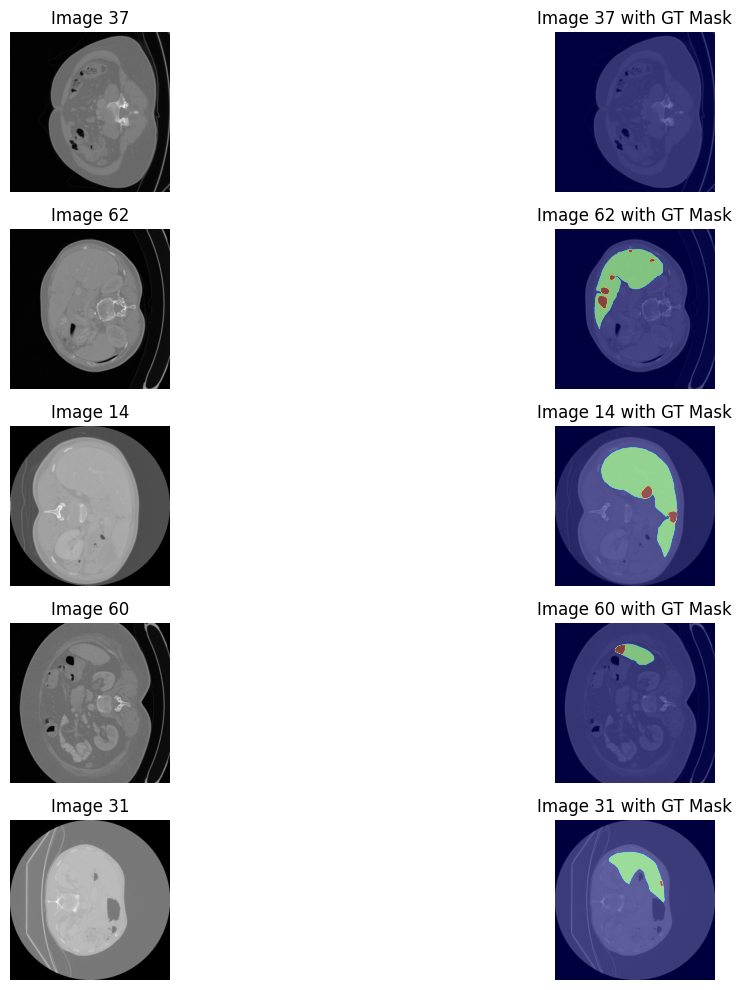

In [7]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import random

# Select 5 random indices from the data_dicts list
random_indices = random.sample(range(len(data_dicts)), 5)

# Create a figure to display the images and masks
plt.figure(figsize=(15, 10))

for i, idx in enumerate(random_indices):
    # Load the image and its corresponding segmentation (GT mask)
    image_file = data_dicts[idx]['image']
    label_file = data_dicts[idx]['label']
    
    # Load the NIfTI image and segmentation files using nibabel
    nib_image = nib.load(image_file)
    nib_label = nib.load(label_file)
    
    # Get the image and segmentation data as NumPy arrays
    image_data = nib_image.get_fdata()
    label_data = nib_label.get_fdata()
    
    # Define the slice index (e.g., middle slice)
    slice_idx = image_data.shape[2] // 2
    
    # Plot the original image
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(image_data[:, :, slice_idx], cmap='gray')
    plt.title(f'Image {idx+1}')
    plt.axis('off')
    
    # Plot the GT mask overlayed on the original image
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(image_data[:, :, slice_idx], cmap='gray')
    plt.imshow(label_data[:, :, slice_idx], cmap='jet', alpha=0.5)
    plt.title(f'Image {idx+1} with GT Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()


# **Setup transforms for training and validation**

https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/spleen_segmentation_3d_visualization_basic.ipynb

https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/unetr_btcv_segmentation_3d.ipynb

# Data Augmentation Transforms

In this section, we apply several transforms to augment the dataset, enhancing the model's ability to generalize by providing diverse training samples.

1. **LoadImaged**:
    - Loads the liver CT images and labels from NIfTI format files.

2. **EnsureChannelFirstd**:
    - Ensures the original data has a "channel first" shape.

3. **Spacingd**:
    - Adjusts the spacing by `pixdim=(1.5, 1.5, 2.0)` based on the affine matrix, ensuring consistent voxel spacing.

4. **Orientationd**:
    - Unifies the data orientation based on the affine matrix.

5. **ScaleIntensityRanged**:
    - Extracts the intensity range `[-57, 164]` and scales it to `[0, 1]`.

6. **CropForegroundd**:
    - Removes all zero borders to focus on the valid body area of the images and labels.

7. **RandCropByPosNegLabeld**:
    - Randomly crops patch samples from the large image based on a positive/negative ratio. The image centers of negative samples must be in the valid body area.

8. **RandAffined**:
    - Efficiently performs rotation, scaling, shearing, translation, and other affine transformations together based on PyTorch affine transform.

9. **EnsureTyped**:
    - Converts the numpy array to a PyTorch Tensor for further steps.


# Data Augmentation and Dataset Preparation

Below, we define the data augmentation and transformation pipelines for training and validation datasets, utilizing MONAI's powerful transform functions. We also prepare the datasets and data loaders for the training process.

### Custom Transformation Class

The `ToLiver` class ensures that all label values of `2` are converted to `1`, simplifying the segmentation problem to a binary classification of liver vs. non-liver.




In [8]:
class ToLiver(object):
    """Convert ndarrays in sample to Tensors and binary labels."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        label[label == 2] = 1  # Convert all labels of 2 to 1
        return {'image': image, 'label': label}

## Training Transformations
The following transformations are applied to the training data to ensure the model generalizes well by encountering diverse variations of the input data.

In [9]:
import numpy as np
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Orientationd, ScaleIntensityRanged,
    CropForegroundd, RandCropByPosNegLabeld, RandFlipd, RandRotate90d
)
from monai.data import CacheDataset, DataLoader

# Set a fixed seed value with np.int64 to avoid overflow
seed = np.long(12345)  # You can choose any integer value here
np.random.seed(seed)

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),  # Load images and labels from files
        EnsureChannelFirstd(keys=["image", "label"]),  # Ensure the channel dimension is first
        Orientationd(keys=["image", "label"], axcodes="RAS"),  # Reorient to RAS (Right-Anterior-Superior)
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57, a_max=164,  # Scale intensity from [-57, 164] to [0, 1]
            b_min=0.0, b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),  # Crop to non-zero regions
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(128, 128, 32),  # Crop to 128x128x32 patches
            pos=1, neg=1,  # Positive/Negative sample ratio
            num_samples=10,  # Number of samples per image
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(keys=["image", "label"], spatial_axis=[0], prob=0.10),  # Random flip along X-axis
        RandFlipd(keys=["image", "label"], spatial_axis=[1], prob=0.10),  # Random flip along Y-axis
        RandFlipd(keys=["image", "label"], spatial_axis=[2], prob=0.10),  # Random flip along Z-axis
        RandRotate90d(keys=["image", "label"], prob=0.10, max_k=3),  # Random rotation by 90 degrees
    ]
)

# Now, create your CacheDataset and DataLoader as usual


c:\Users\ojshav\miniconda3\envs\monai\lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


## Validation Transformations
The validation transformations are similar but exclude random augmentations to ensure consistent evaluation.

In [10]:
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),  # Load images and labels from files
        EnsureChannelFirstd(keys=["image", "label"]),  # Ensure the channel dimension is first
        Orientationd(keys=["image", "label"], axcodes="RAS"),  # Reorient to RAS (Right-Anterior-Superior)
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57, a_max=164,  # Scale intensity from [-57, 164] to [0, 1]
            b_min=0.0, b_max=1.0,
            clip=True,
        ),
        # CropForegroundd is commented out to retain full image context in validation
    ]
)


## Creating Datasets and Data Loaders
We use the CacheDataset for efficient data loading by caching the data in memory, and create data loaders for batching and shuffling the data during training.

In [11]:
train_ds = CacheDataset(data=train_files, transform=train_transforms)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)

val_ds = CacheDataset(data=val_files, transform=val_transforms)


Loading dataset: 100%|██████████| 7/7 [00:19<00:00,  2.86s/it]


# Validation Dataset Preparation and Visualization

In this section, we create the validation dataset and visualize one of the validation samples, both the image and the corresponding label, using matplotlib.

### Creating the Validation Dataset

We create a validation dataset using MONAI's `Dataset` class, which handles the loading and transformation of data.

```python


### Accessing and Visualizing a Validation Sample
We access the first sample from the validation dataset and convert the tensors to numpy arrays for visualization. Then, we display the image and label using matplotlib.

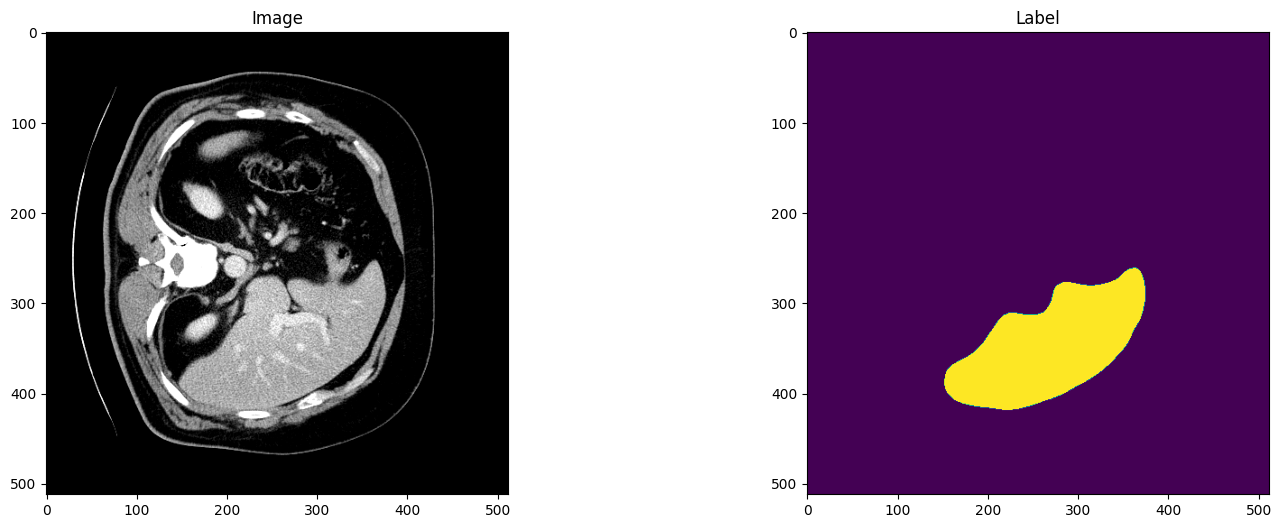

In [12]:
import matplotlib.pyplot as plt

# Access the first image and label from the validation dataset
img = val_ds[0]["image"]
label = val_ds[0]["label"]

# Convert tensors to numpy arrays
img_np = img[0, :, :, -30].detach().cpu().numpy()
label_np = label[0, :, :, -30].detach().cpu().numpy()

# Show images
plt.figure("images", (18, 6))  # Create a figure with a specified size
plt.subplot(1, 2, 1)  # Add a subplot for the image
plt.title("Image")  # Set the title for the image subplot
plt.imshow(img_np, cmap="gray")  # Display the image in grayscale
plt.subplot(1, 2, 2)  # Add a subplot for the label
plt.title("Label")  # Set the title for the label subplot
plt.imshow(label_np)  # Display the label
plt.show()  # Show the figure with the image and label subplots


# Patch Sampling and Visualization

In this section, we implement custom patch sampling functions to extract patches from the liver CT images and labels. We then create datasets using these patches and visualize some of the patches.

### Importing Necessary Libraries

We start by importing the necessary libraries.

```python



## Defining Patch Sampling Functions
We define functions to sample patches from the labels and images. The patches are sampled based on the presence of liver and tumor regions.

### Crop Label Function
The Crop_label function identifies regions with tumors in the label and records the indices of these regions.

In [13]:
inds = []

def Crop_label(label):
    """Sample patches from the label with a focus on tumor regions."""
    r = []
    tumor = 0
    
    if label.shape[0] == 1:
        label = label[0]
    x, y, z = label.shape
    while tumor < 10:
        i = random.randint(0,x - 128)
        j = random.randint(0,y - 128)
        k = random.randint(0,z - 32)
        
        unique_num = np.unique(label[i:i+128, j:j+128, k:k+32])
        if 2 in unique_num and tumor < 10:
            tumor += 1
            inds.append([i, j, k])
    
    return inds


### Crop Image Function
The `Crop_img` function extracts patches from the image based on the indices recorded by the Crop_label function.



In [14]:
def Crop_img(img, samples_per_image=10):
    """Extract patches from the image based on pre-recorded indices."""
    r = []
    
    if img.shape[0] == 1:
        img = img[0]
    x, y, z = img.shape
    
    # Repeat indices if there are not enough
    while len(inds) < samples_per_image:
        inds.extend(inds[:samples_per_image - len(inds)])
    
    for ind in inds[:samples_per_image]:
        i, j, k = ind
        # Ensure the patch is within the image bounds
        if i+128 <= x and j+128 <= y and k+32 <= z:
            r.append(img[i:i+128, j:j+128, k:k+32])
    
    return r


### Applying the Functions to the Dataset
We apply the patch sampling functions to the validation dataset to create patch datasets for both the images and the labels.

In [15]:
# Image-level dataset
img = val_ds[0]["image"]
label = val_ds[0]["label"]

print(img.shape)

# Sample patches from the labels
inds = Crop_label(label)

# Create patch datasets for images and labels
ds_l = PatchDataset(data=label, patch_func=Crop_img, samples_per_image=10)
ds_i = PatchDataset(data=img, patch_func=Crop_img, samples_per_image=10)

# Create data loaders for the patch datasets
val_loader1 = DataLoader(ds_i, batch_size=1)
val_loader2 = DataLoader(ds_l, batch_size=1)

torch.Size([1, 512, 512, 121])


### Visualizing the Patches
Finally, we visualize some of the patches from the image and label datasets.

Patch 1 - Image Patch Shape: torch.Size([1, 128, 128, 32]), Label Patch Shape: torch.Size([1, 128, 128, 32])


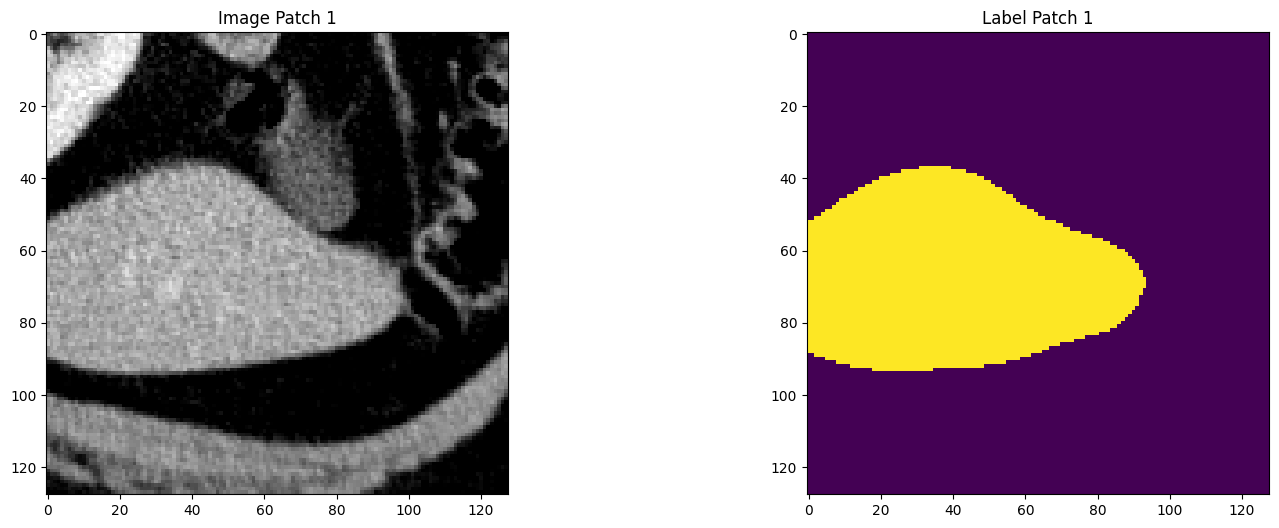

Patch 2 - Image Patch Shape: torch.Size([1, 128, 128, 32]), Label Patch Shape: torch.Size([1, 128, 128, 32])


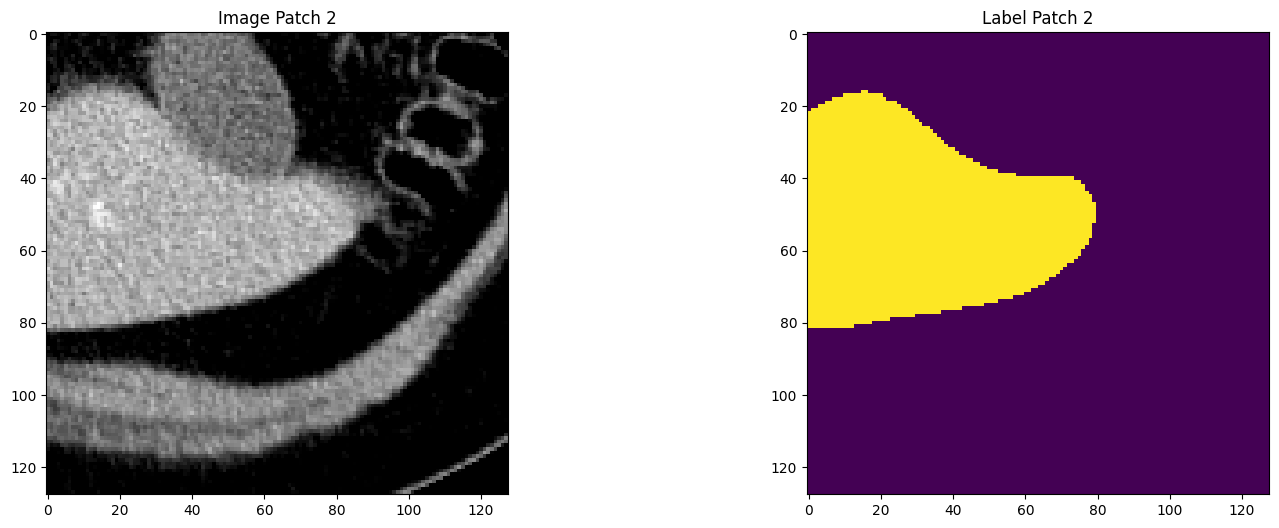

Patch 3 - Image Patch Shape: torch.Size([1, 128, 128, 32]), Label Patch Shape: torch.Size([1, 128, 128, 32])


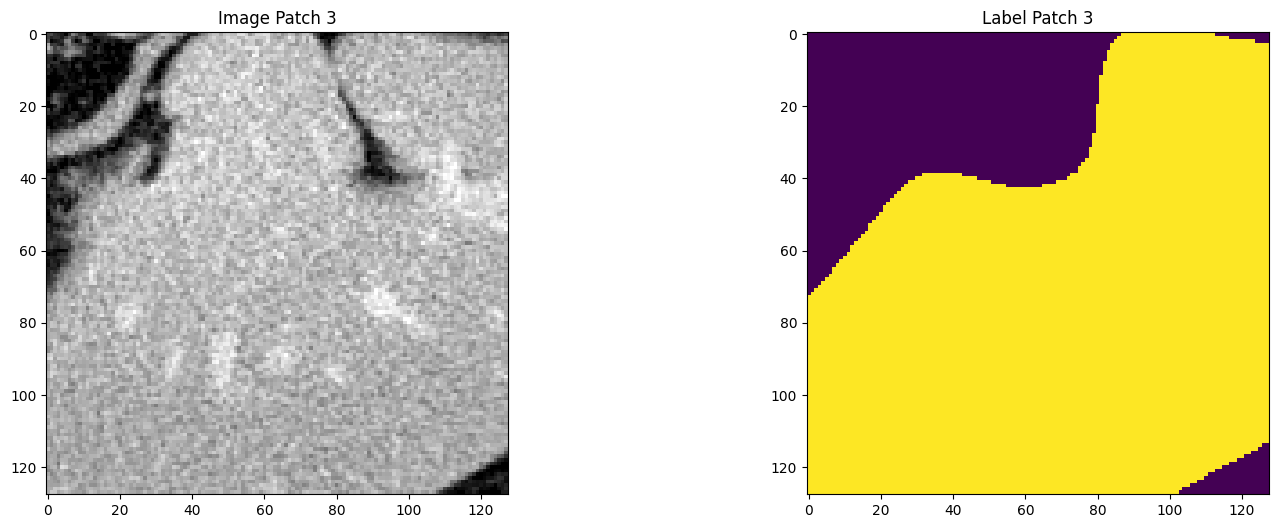

Patch 4 - Image Patch Shape: torch.Size([1, 128, 128, 32]), Label Patch Shape: torch.Size([1, 128, 128, 32])


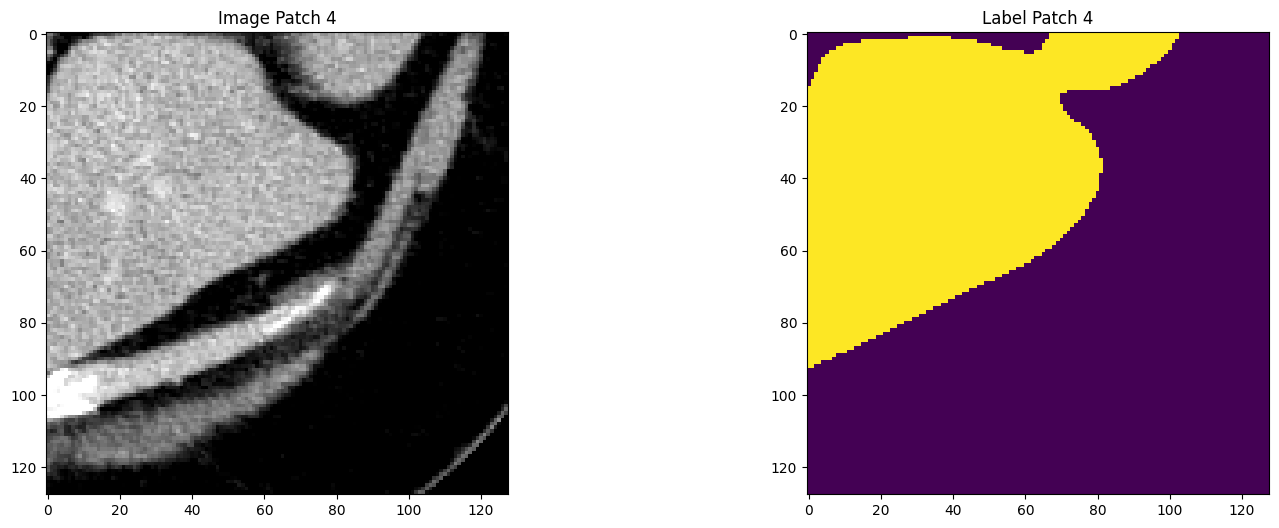

Patch 5 - Image Patch Shape: torch.Size([1, 128, 128, 32]), Label Patch Shape: torch.Size([1, 128, 128, 32])


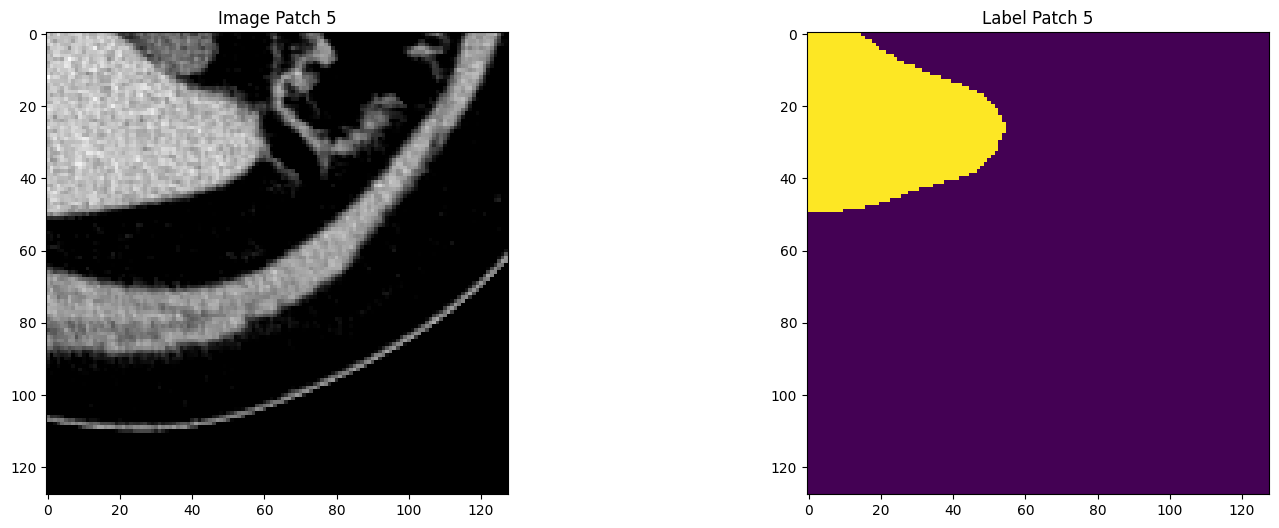

Patch 6 - Image Patch Shape: torch.Size([1, 128, 128, 32]), Label Patch Shape: torch.Size([1, 128, 128, 32])


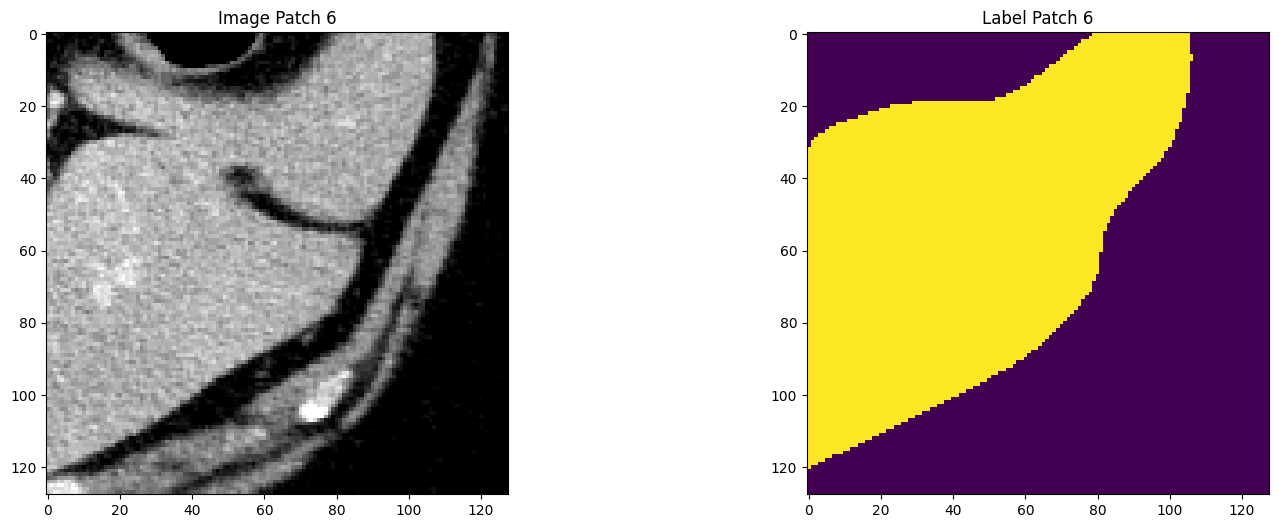

Patch 7 - Image Patch Shape: torch.Size([1, 128, 128, 32]), Label Patch Shape: torch.Size([1, 128, 128, 32])


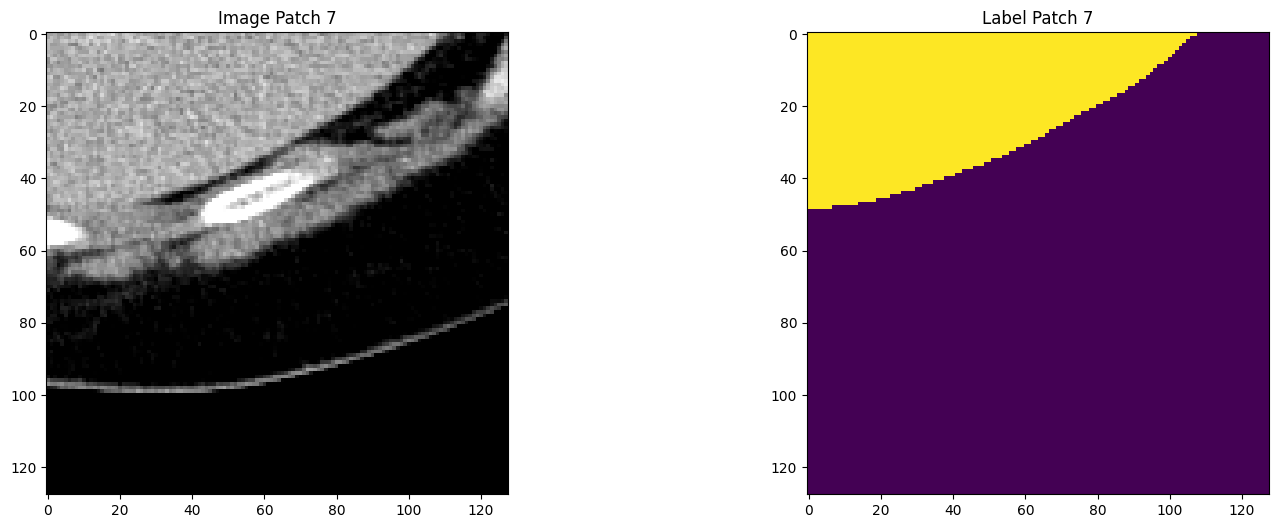

Patch 8 - Image Patch Shape: torch.Size([1, 128, 128, 32]), Label Patch Shape: torch.Size([1, 128, 128, 32])


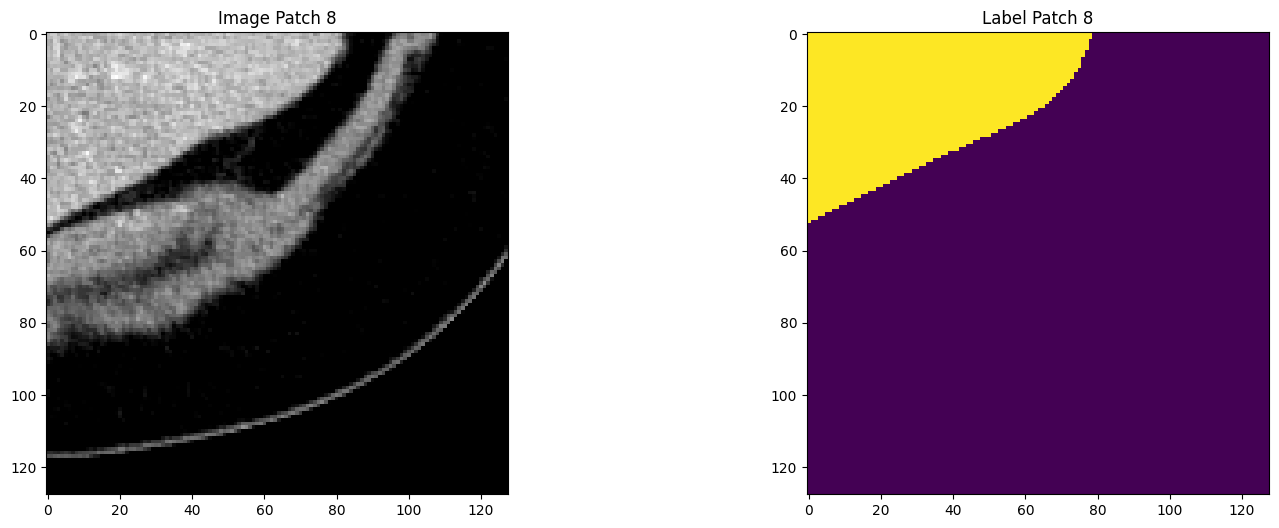

Patch 9 - Image Patch Shape: torch.Size([1, 128, 128, 32]), Label Patch Shape: torch.Size([1, 128, 128, 32])


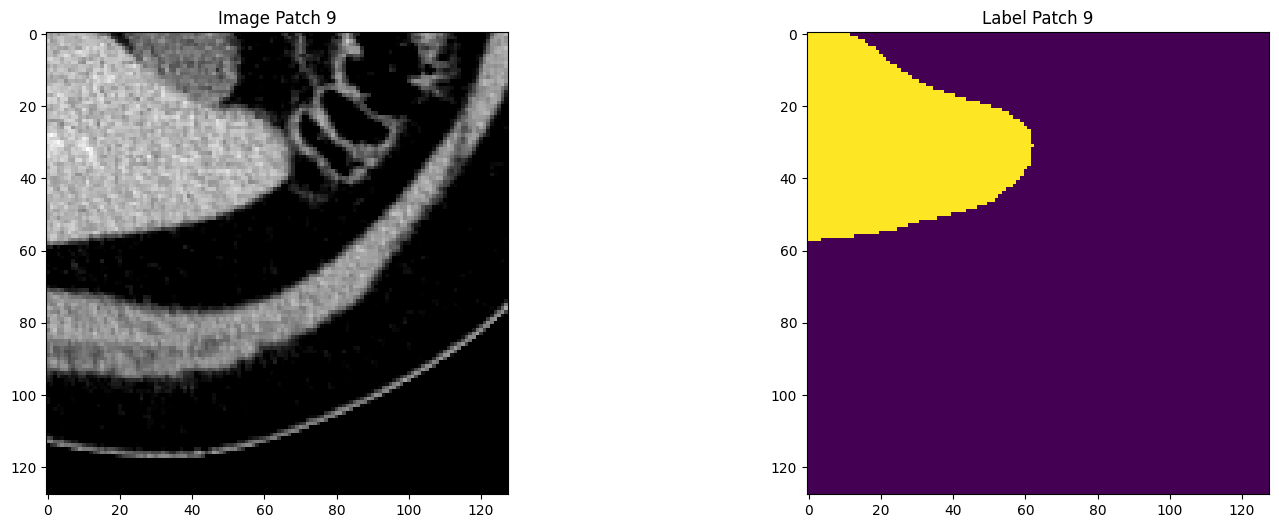

Patch 10 - Image Patch Shape: torch.Size([1, 128, 128, 32]), Label Patch Shape: torch.Size([1, 128, 128, 32])


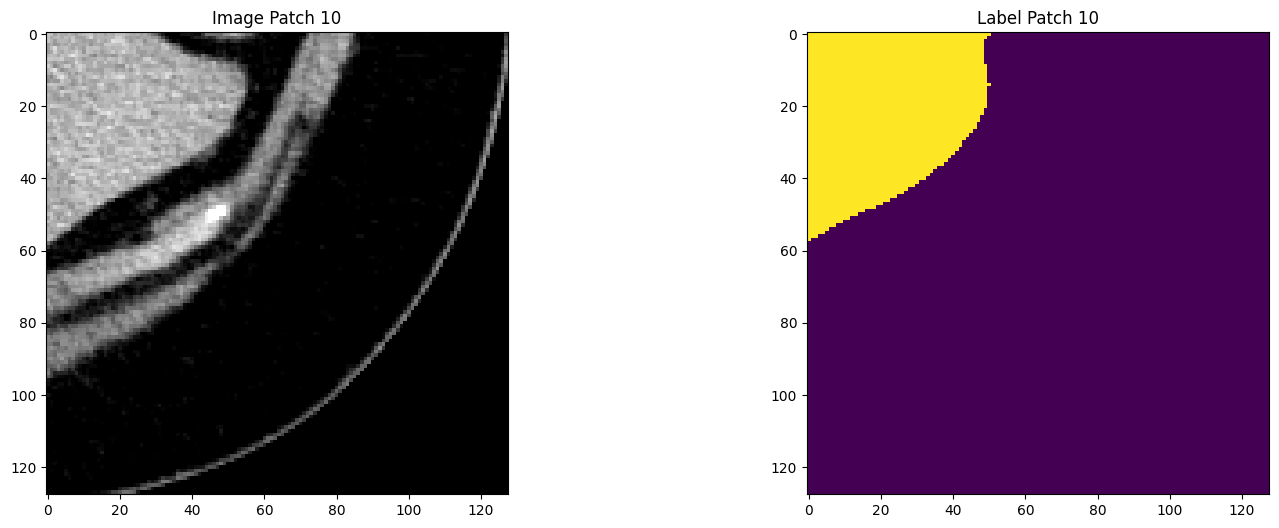

In [16]:
import matplotlib.pyplot as plt

# Iterate over the patches in both the image and label data loaders
for i, (img_patch, label_patch) in enumerate(zip(val_loader1, val_loader2)):
    # Print the shapes of the image and label patches
    print(f"Patch {i+1} - Image Patch Shape: {img_patch.shape}, Label Patch Shape: {label_patch.shape}")
    
    # Visualize the patch
    plt.figure("Patch Visualization", (18, 6))
    plt.subplot(1, 2, 1)
    plt.title(f"Image Patch {i+1}")
    plt.imshow(img_patch[0, :, :, 5].detach().cpu(), cmap="gray")
    plt.subplot(1, 2, 2)
    plt.title(f"Label Patch {i+1}")
    plt.imshow(label_patch[0, :, :, 5].detach().cpu())
    plt.show()


## UNet Model Training with MONAI 
This code snippet sets up and initializes a 3D UNet model for semantic segmentation using the MONAI library. It includes the definition of the model, loss function, optimizer, metrics, and the use of Aim for experiment tracking.

In [17]:
import os
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from monai.networks.nets import Unet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric, MeanIoU
from monai.transforms import Compose, AsDiscrete
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define the root directory
root_dir = 'monai_result'

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize TensorBoard SummaryWriter
log_dir = os.path.join(root_dir, "logs")
writer = SummaryWriter(log_dir=log_dir)

# Define the UNet model
model =UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=3,
    channels= (8,16,32,64),
    strides=(2,2,2),
).to(device)

# Define the loss function and optimizer with weight decay
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

## Training Loop Summary
This section explains the overall structure and key components of the training loop used for training a medical image segmentation model.

### Key Components
- Learning Rate Scheduler:
A ReduceLROnPlateau scheduler adjusts the learning rate when the model’s performance plateaus, helping to stabilize training.

- Post-Processing Transforms:
post_pred and post_label convert predictions and labels into a format suitable for evaluation (one-hot encoding and applying argmax).

- Evaluation Metrics:
The model’s performance is measured using the Dice and IoU metrics, both calculated on the validation set after each epoch.

### Training Process
- Gradient Accumulation:
Gradients are accumulated over multiple steps to effectively increase the batch size without requiring more memory.

- Validation Function:
After each epoch, the model is evaluated on the validation set, and the Dice and IoU metrics are calculated.

- Model Checkpointing:
The best model based on Dice and IoU metrics is saved during training.

- Learning Rate Adjustment:
The learning rate is reduced if the training loss does not improve for a specified number of epochs.

- Iteration Through Epochs
The loop runs for a specified number of epochs, updating the model, tracking performance metrics, and adjusting the learning rate as needed. The best models based on Dice and IoU are saved for later use.

In [18]:
# Define the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

# Define post transforms and metrics for evaluation
post_label = AsDiscrete(to_onehot=3)
post_pred = AsDiscrete(argmax=True, to_onehot=3)
dice_metric = DiceMetric(include_background=True, reduction="mean")
iou_metric = MeanIoU(include_background=True, reduction="mean")

# Training parameters
max_epochs = 15
accumulation_steps = 4  # Number of steps to accumulate gradients

# Initialize tracking variables
global_step = 0
dice_val_best = 0.0
iou_val_best = 0.0
global_step_best_dice = 0
global_step_best_iou = 0

# Initialize lists to store metrics
epoch_loss_values = []
dice_metric_values = []
iou_metric_values = []
lrs = []

# Validation function
def validation(val_loader):
    model.eval()
    val_labels_convert = []
    val_outputs_convert = []

    with torch.no_grad():
        for step, batch in enumerate(zip(val_loader1, val_loader2)):
            val_inputs, val_labels = batch
            val_inputs = val_inputs[None, :, :, :, :].to(device)
            val_labels = val_labels[None, :, :, :, :].to(device)
            
            val_outputs = model(val_inputs)
            
            val_labels_convert.append(post_label(decollate_batch(val_labels)[0])[0])
            val_outputs_convert.append(post_pred(decollate_batch(val_outputs)[0])[0])
        
        dice_metric(y_pred=val_outputs_convert, y=val_labels_convert)
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()

        iou_metric(y_pred=val_outputs_convert, y=val_labels_convert)
        mean_iou_val = iou_metric.aggregate().item()
        iou_metric.reset()

    return mean_dice_val, mean_iou_val

# Training function
def train(epoch, train_loader, val_loader, dice_val_best, iou_val_best, global_step_best_dice, global_step_best_iou):
    model.train()
    epoch_loss = 0
    epoch_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epochs}", dynamic_ncols=True)

    for step, batch in enumerate(epoch_iterator):
        x, y = (batch["image"].to(device), batch["label"].to(device))
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss = loss / accumulation_steps  # Normalize loss by accumulation steps
        loss.backward()

        if (step + 1) % accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Apply gradient clipping
            optimizer.step()
            optimizer.zero_grad()

        epoch_loss += loss.item() * accumulation_steps  # Accumulate the actual loss

    epoch_loss /= (step + 1)  # Average loss over the steps
    epoch_loss_values.append(epoch_loss)

    # Log loss to TensorBoard
    writer.add_scalar("Loss/train", epoch_loss, epoch)

    dice_val, iou_val = validation(val_loader)
    dice_metric_values.append(dice_val)
    iou_metric_values.append(iou_val)

    # Log metrics to TensorBoard
    writer.add_scalar("Dice Validation", dice_val, epoch)
    writer.add_scalar("IoU Validation", iou_val, epoch)

    if dice_val > dice_val_best:
        dice_val_best = dice_val
        global_step_best_dice = epoch
        torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
        print(f"Model Saved! Current Best Dice: {dice_val_best:.4f}")

    if iou_val > iou_val_best:
        iou_val_best = iou_val
        global_step_best_iou = epoch
        torch.save(model.state_dict(), os.path.join(root_dir, "best_iou_model.pth"))
        print(f"Model Saved! Current Best IoU: {iou_val_best:.4f}")

    scheduler.step(epoch_loss)
    lrs.append(optimizer.param_groups[0]["lr"])

    return dice_val_best, iou_val_best, global_step_best_dice, global_step_best_iou

# Iterate through epochs
for epoch in range(max_epochs):
    dice_val_best, iou_val_best, global_step_best_dice, global_step_best_iou = train(
        epoch, train_loader, val_loader1, dice_val_best, iou_val_best, global_step_best_dice, global_step_best_iou
    )

model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
print(f"Training completed, best Dice: {dice_val_best:.4f} at epoch: {global_step_best_dice}")

model.load_state_dict(torch.load(os.path.join(root_dir, "best_iou_model.pth")))
print(f"Training completed, best IoU: {iou_val_best:.4f} at epoch: {global_step_best_iou}")

# Close the TensorBoard writer
writer.close()

c:\Users\ojshav\miniconda3\envs\monai\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/15: 100%|██████████| 50/50 [00:11<00:00,  4.31it/s]


Model Saved! Current Best Dice: 0.7528
Model Saved! Current Best IoU: 0.6176


Epoch 2/15: 100%|██████████| 50/50 [00:10<00:00,  4.70it/s]


Model Saved! Current Best Dice: 0.8592
Model Saved! Current Best IoU: 0.7660


Epoch 3/15: 100%|██████████| 50/50 [00:10<00:00,  4.77it/s]


Model Saved! Current Best Dice: 0.8740
Model Saved! Current Best IoU: 0.7898


Epoch 4/15: 100%|██████████| 50/50 [00:10<00:00,  4.75it/s]


Model Saved! Current Best Dice: 0.8812
Model Saved! Current Best IoU: 0.8007


Epoch 5/15: 100%|██████████| 50/50 [00:12<00:00,  3.97it/s]


Model Saved! Current Best Dice: 0.9024
Model Saved! Current Best IoU: 0.8333


Epoch 6/15: 100%|██████████| 50/50 [00:09<00:00,  5.13it/s]


Model Saved! Current Best Dice: 0.9156
Model Saved! Current Best IoU: 0.8539


Epoch 8/15: 100%|██████████| 50/50 [00:10<00:00,  4.86it/s]


Model Saved! Current Best Dice: 0.9232
Model Saved! Current Best IoU: 0.8663


Epoch 9/15: 100%|██████████| 50/50 [00:10<00:00,  4.83it/s]


Model Saved! Current Best Dice: 0.9281
Model Saved! Current Best IoU: 0.8744


Epoch 11/15: 100%|██████████| 50/50 [00:09<00:00,  5.08it/s]


Model Saved! Current Best Dice: 0.9333
Model Saved! Current Best IoU: 0.8831


Epoch 12/15: 100%|██████████| 50/50 [00:10<00:00,  4.66it/s]


Model Saved! Current Best Dice: 0.9349
Model Saved! Current Best IoU: 0.8847


Epoch 14/15: 100%|██████████| 50/50 [00:11<00:00,  4.37it/s]


Model Saved! Current Best Dice: 0.9415
Model Saved! Current Best IoU: 0.8967


Epoch 15/15: 100%|██████████| 50/50 [00:10<00:00,  4.62it/s]


Training completed, best Dice: 0.9415 at epoch: 13
Training completed, best IoU: 0.8967 at epoch: 13


C:\Users\ojshav\AppData\Local\Temp\ipykernel_9360\2344996251.py:111: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "b

## Plotting Training Metrics
This code snippet uses Matplotlib to create and display plots for training loss, Dice metric, and IoU metric over epochs. These plots help visualize the model's performance and progress during training.

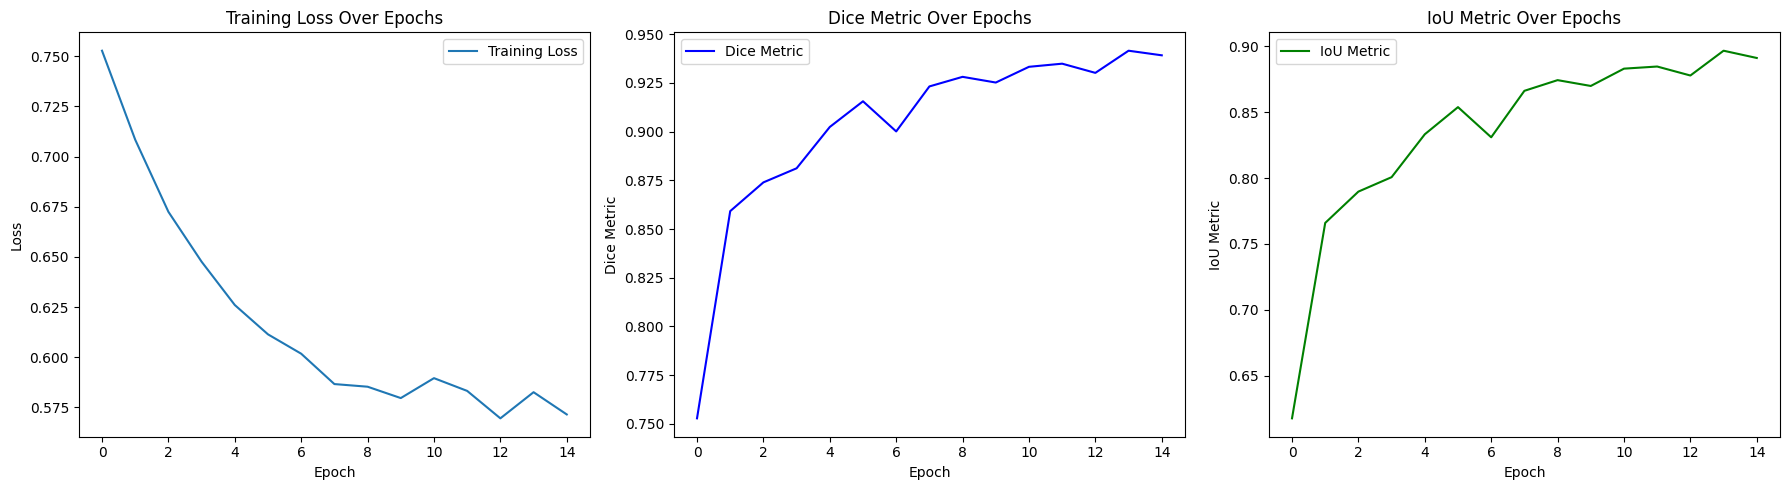

In [19]:
# Plotting the graphs
plt.figure(figsize=(18, 5))

# Plot training loss
plt.subplot(1, 3, 1)
plt.plot(epoch_loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot Dice metrics
plt.subplot(1, 3, 2)
plt.plot(dice_metric_values, label='Dice Metric', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Dice Metric')
plt.title('Dice Metric Over Epochs')
plt.legend()

# Plot IoU metrics
plt.subplot(1, 3, 3)
plt.plot(iou_metric_values, label='IoU Metric', color='green')
plt.xlabel('Epoch')
plt.ylabel('IoU Metric')
plt.title('IoU Metric Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


## Testing and Visualization
This code snippet demonstrates how to preprocess test data, perform inference with a trained model, and visualize the results. It uses MONAI for data handling and PyTorch for model inference.

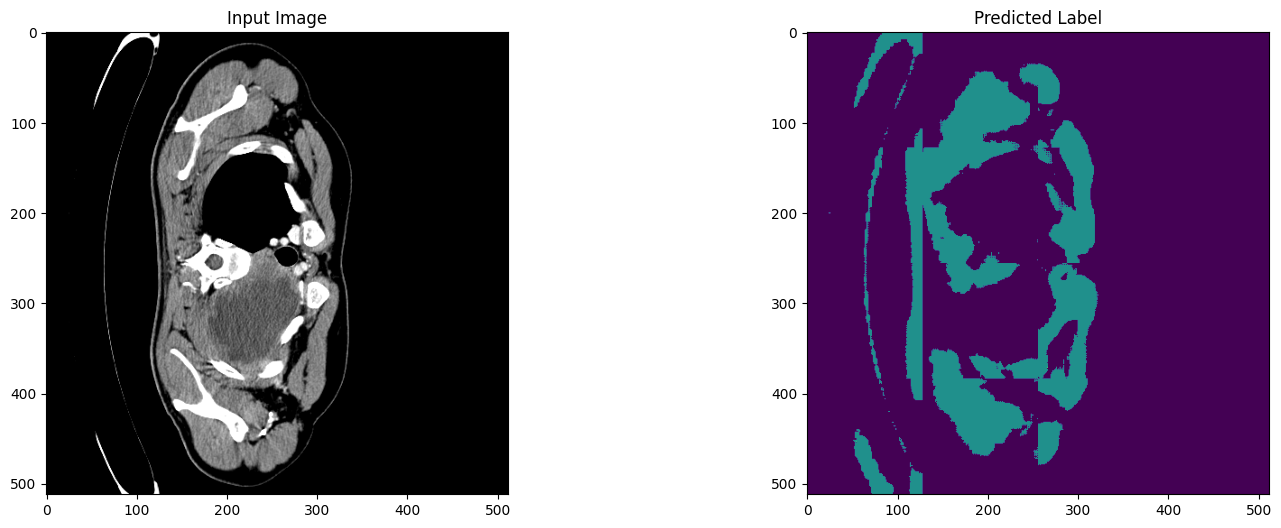

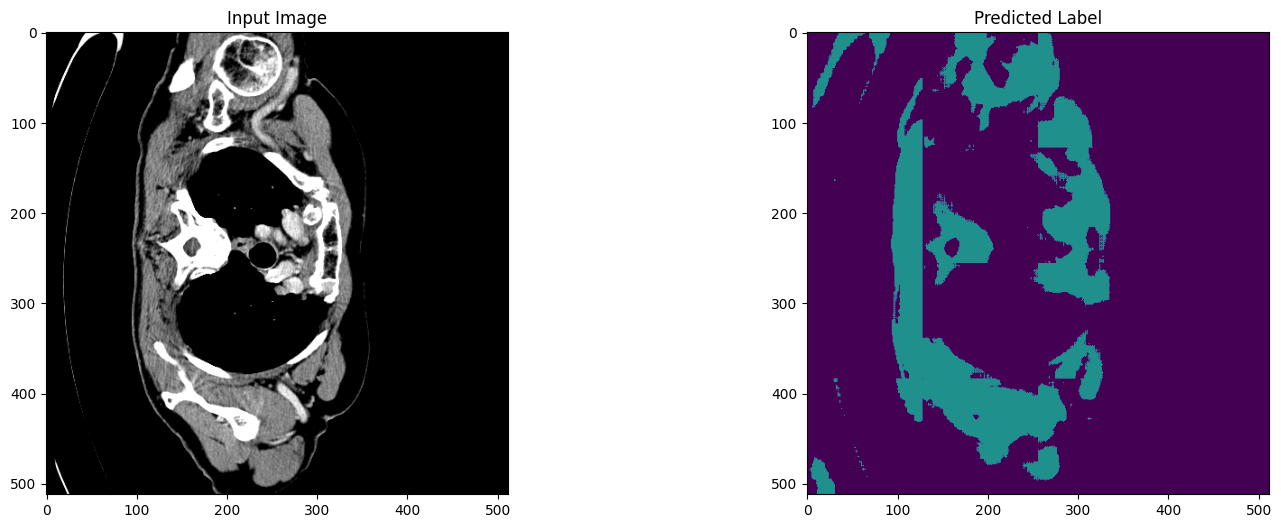

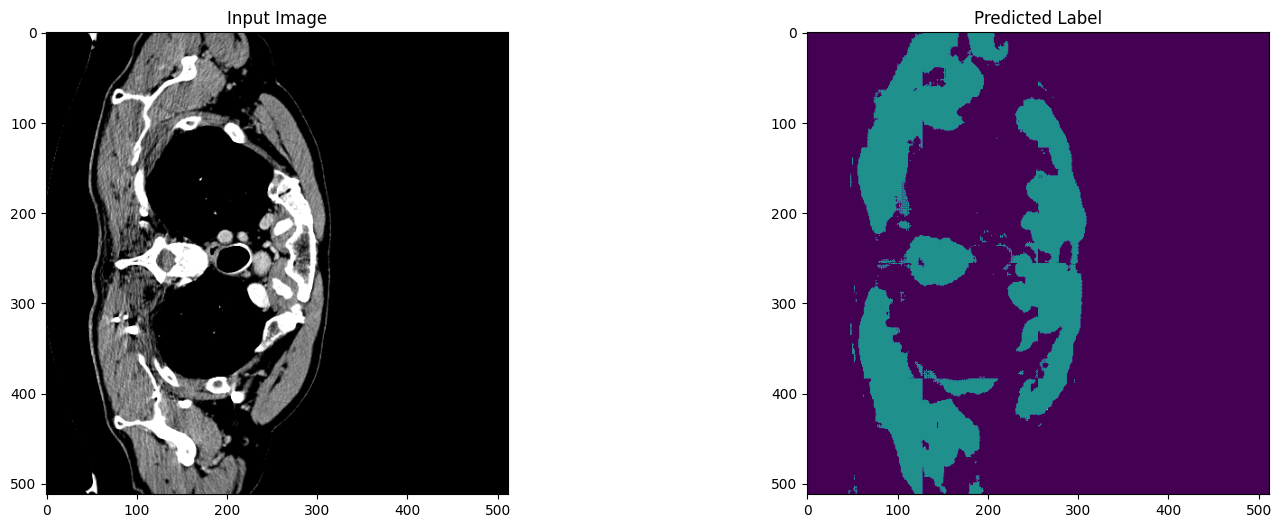

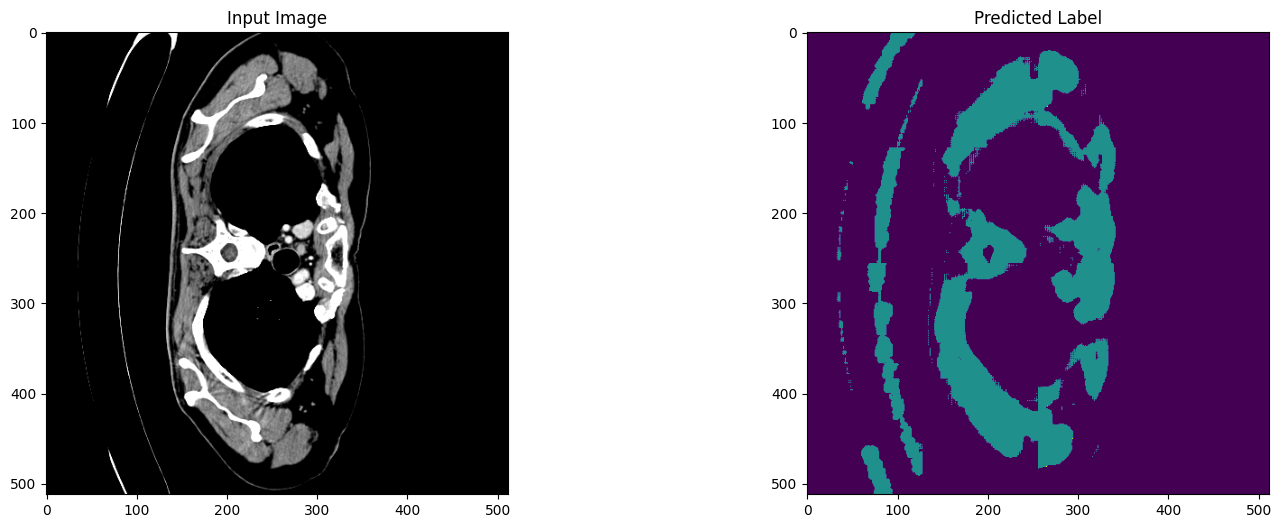

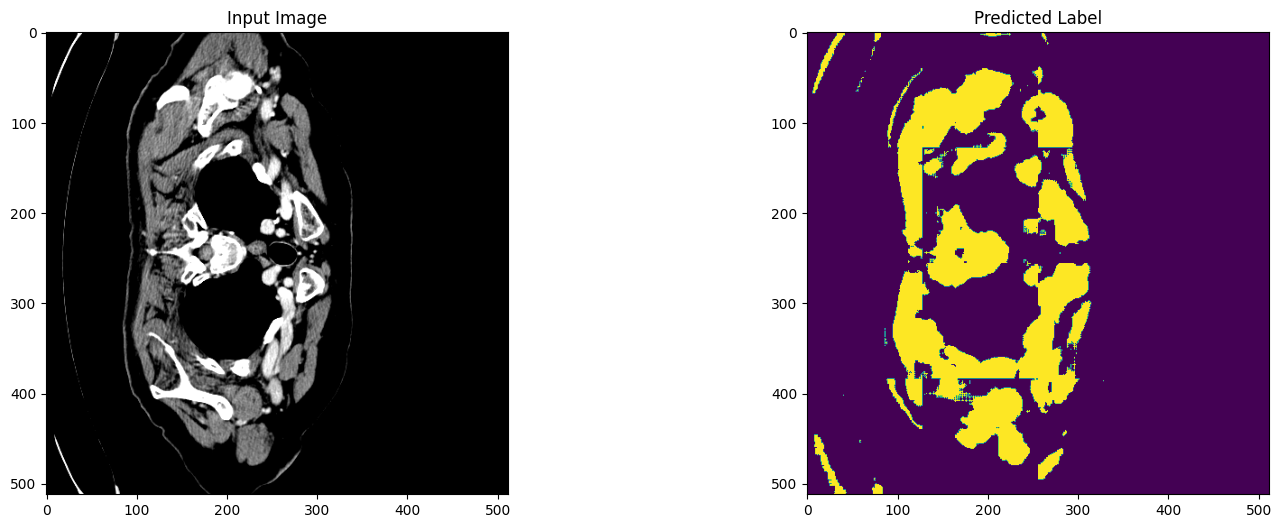

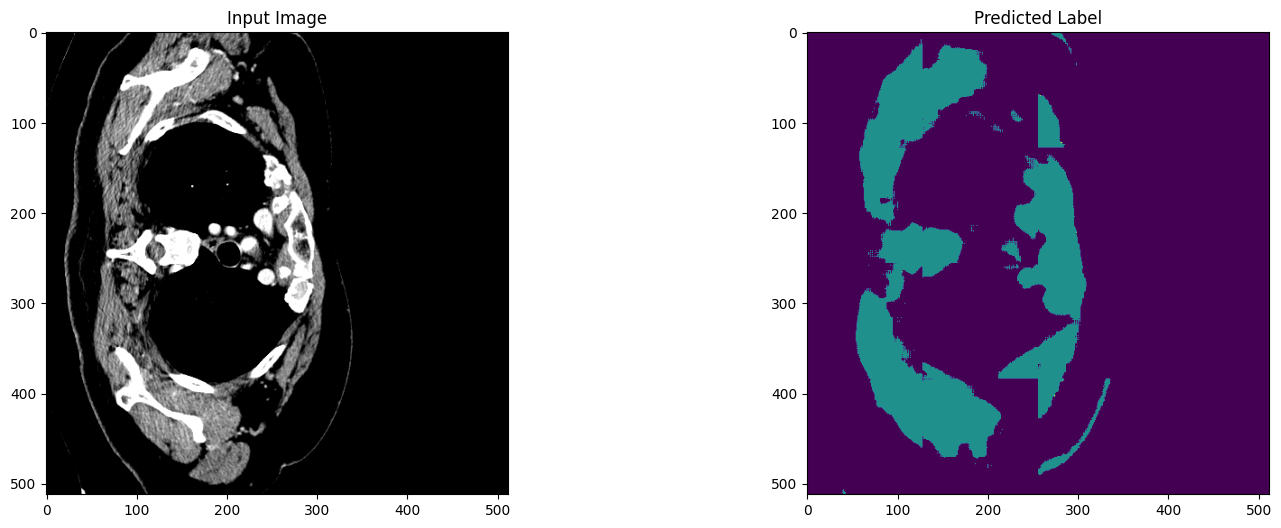

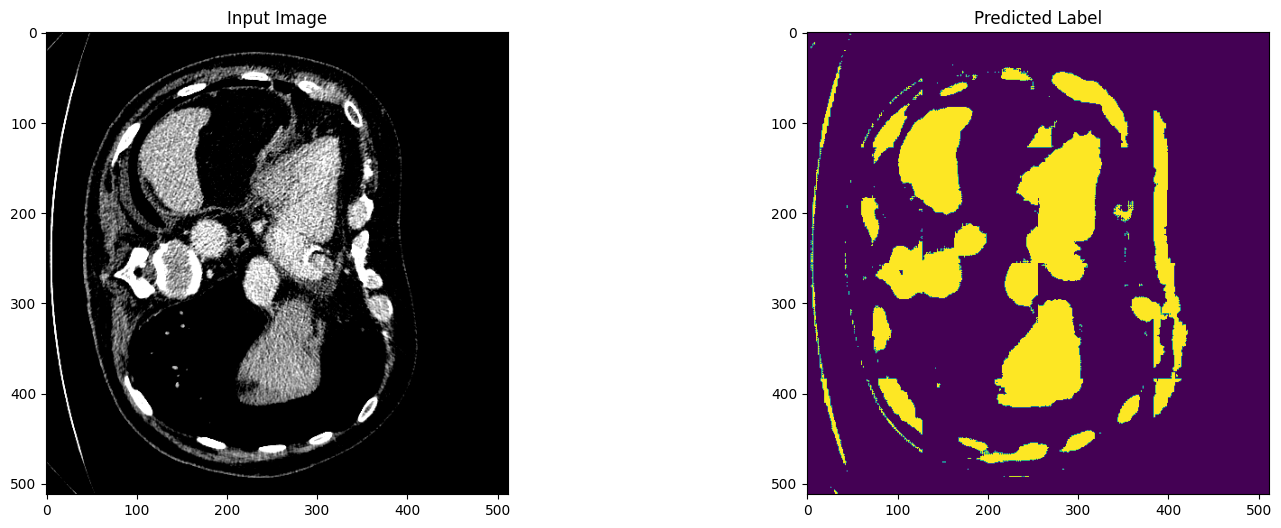

In [20]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from monai.data import Dataset, DataLoader
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, Orientationd, ScaleIntensityRanged
from torch.utils.tensorboard import SummaryWriter

# Define the test transformations
test_transforms = Compose([
    LoadImaged(keys=["image", "label"]),  # Load images and labels from disk
    EnsureChannelFirstd(keys=["image", "label"]),  # Ensure the channel dimension is first
    Orientationd(keys=["image", "label"], axcodes="RAS"),  # Reorient images to RAS (Right-Anterior-Superior)
    ScaleIntensityRanged(keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),  # Scale image intensity
])

# Create the test dataset
test_ds = Dataset(data=test_files, transform=test_transforms)  # Apply transformations to test data

# Define your test data loader
test_loader = DataLoader(test_ds, batch_size=2, shuffle=True)  # Create data loader for test data

# Initialize TensorBoard SummaryWriter
writer = SummaryWriter(log_dir="runs/test_experiment")

# Function to get indices for patch sampling
def get_inds(img):
    inds = []
    if img.shape[0] == 1:
        img = img[0]  # Remove channel dimension if present
    x, y, z = img.shape
    for i in range(127, x, 128):  # Generate indices for patches
        for j in range(127, y, 128):
            for k in range(31, z, 32):
                inds.append([i, j, k])
    return inds

# Iterate over the dataset
for idx in range(len(test_ds)):
    # Get the input image and move it to the GPU
    sample = test_ds[idx]
    img = sample["image"].cuda()
    
    # Predict liver segmentation
    indsf = get_inds(img)  # Get patch indices
    label = torch.zeros_like(img).cuda()  # Initialize tensor for predictions
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient computation for inference
        for ind in indsf:
            i, j, k = ind
            x = img[None, :, i - 127:i + 1, j - 127:j + 1, k - 31:k + 1]  # Extract patch
            label[:, i - 127:i + 1, j - 127:j + 1, k - 31:k + 1] = torch.argmax(model(x), axis=1)  # Predict and store

    # Log the input image and predicted label to TensorBoard
    writer.add_images(f"Input/Image_{idx}", img[None, :, :, :, -34].detach().cpu(), idx)
    writer.add_images(f"Prediction/Label_{idx}", label[None, :, :, :, -34].detach().cpu(), idx)

    # Plot and show the images
    plt.figure(figsize=(18, 6))

    # Plot input image
    plt.subplot(1, 2, 1)
    plt.imshow(img[0, :, :, -34].detach().cpu(), cmap="gray")  # Show a slice of the input image
    plt.title("Input Image")

    # Plot predicted label
    plt.subplot(1, 2, 2)
    plt.imshow(label[0, :, :, -34].detach().cpu())  # Show a slice of the predicted label
    plt.title("Predicted Label")
    
    plt.show()  # Display the plots

# Close the TensorBoard writer
writer.close()


In [21]:
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, jaccard_score, confusion_matrix
from tqdm import tqdm

# Initialize TensorBoard SummaryWriter
writer = SummaryWriter(log_dir='./logs')

# Initialize accumulators for the sum of metrics
dice_sum = 0.0
iou_sum = 0.0
accuracy_sum = 0.0
precision_sum = 0.0
f1_sum = 0.0
recall_sum = 0.0
specificity_sum = 0.0
sensitivity_sum = 0.0
jaccard_sum = 0.0

# Function to calculate Dice score
def dice_score(pred, target):
    smooth = 1e-5
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

# Function to calculate specificity and sensitivity for each class
def specificity_sensitivity(cm):
    specificities = []
    sensitivities = []
    
    for i in range(len(cm)):  # Iterate over each class
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))  # True negatives
        fp = np.sum(np.delete(cm, i, axis=0)[:, i])  # False positives
        fn = np.sum(cm[i, :]) - cm[i, i]  # False negatives
        tp = cm[i, i]  # True positives
        
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        specificities.append(specificity)
        sensitivities.append(sensitivity)
    
    return np.mean(specificities), np.mean(sensitivities)  # Return mean specificity and sensitivity

# Iterate over the test dataset with a loading bar
for idx in tqdm(range(len(test_ds)), desc="Processing"):
    # Get the input image and move it to the GPU
    sample = test_ds[idx]
    img = sample["image"].cuda()
    true_label = sample["label"].cpu().numpy()  # Get the true label

    # Predict liver segmentation
    indsf = get_inds(img)
    pred_label = torch.zeros_like(img).cuda()  
    model.eval()  
    with torch.no_grad():  
        for ind in indsf:
            i, j, k = ind
            x = img[None, :, i - 127:i + 1, j - 127:j + 1, k - 31:k + 1]  
            pred_label[:, i - 127:i + 1, j - 127:j + 1, k - 31:k + 1] = torch.argmax(model(x), axis=1)  

    pred_label_np = pred_label.cpu().numpy()

    # Flatten the arrays for metric computation
    pred_flat = pred_label_np.flatten()
    true_flat = true_label.flatten()

    # Calculate metrics and accumulate their sum
    dice_sum += dice_score(pred_flat, true_flat)
    iou_sum += jaccard_score(true_flat, pred_flat, average='macro')
    accuracy_sum += accuracy_score(true_flat, pred_flat)
    precision_sum += precision_score(true_flat, pred_flat, average='macro')
    recall_sum += recall_score(true_flat, pred_flat, average='macro')
    f1_sum += f1_score(true_flat, pred_flat, average='macro')
    cm = confusion_matrix(true_flat, pred_flat)
    specificity, sensitivity = specificity_sensitivity(cm)
    specificity_sum += specificity
    sensitivity_sum += sensitivity
    jaccard_sum += jaccard_score(true_flat, pred_flat, average='macro')

# Calculate average metrics
num_samples = len(test_ds)
avg_dice = dice_sum / num_samples
avg_iou = iou_sum / num_samples
avg_accuracy = accuracy_sum / num_samples
avg_precision = precision_sum / num_samples
avg_f1 = f1_sum / num_samples
avg_recall = recall_sum / num_samples
avg_specificity = specificity_sum / num_samples
avg_sensitivity = sensitivity_sum / num_samples
avg_jaccard = jaccard_sum / num_samples

# Log the metrics to TensorBoard
writer.add_scalar('Test/Average Dice', avg_dice)
writer.add_scalar('Test/Average IoU', avg_iou)
writer.add_scalar('Test/Average Accuracy', avg_accuracy)
writer.add_scalar('Test/Average Precision', avg_precision)
writer.add_scalar('Test/Average F1 Score', avg_f1)
writer.add_scalar('Test/Average Recall', avg_recall)
writer.add_scalar('Test/Average Specificity', avg_specificity)
writer.add_scalar('Test/Average Sensitivity', avg_sensitivity)
writer.add_scalar('Test/Average Jaccard Index', avg_jaccard)

# Print average metrics
print(f"Average Dice Score: {avg_dice:.4f}")
print(f"Average IoU Score: {avg_iou:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average Specificity: {avg_specificity:.4f}")
print(f"Average Sensitivity: {avg_sensitivity:.4f}")
print(f"Average Jaccard Index: {avg_jaccard:.4f}")

# Close the TensorBoard writer
writer.close()


Processing: 100%|██████████| 7/7 [08:00<00:00, 68.67s/it]

Average Dice Score: 0.2454
Average IoU Score: 0.3270
Average Accuracy: 0.8433
Average Precision: 0.3804
Average F1 Score: 0.3833
Average Recall: 0.5963
Average Specificity: 0.9215
Average Sensitivity: 0.5963
Average Jaccard Index: 0.3270


In [22]:
%load_ext tensorboard
%tensorboard --logdir=./logs


Reusing TensorBoard on port 6009 (pid 10520), started 22:42:24 ago. (Use '!kill 10520' to kill it.)